**1. Instalación y Carga de Librerías**

In [6]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# **Entrenamiento y Testeo de un Modelo de Análisis de Sentimiento**

**1. Preparar los datos**

Cargar y dividir los datos: Vamos a dividir los datos preprocesados en entrenamiento (train) y test, aplicando undersampling a la clase mayoritaria

In [10]:
# Cargar el dataset preprocesado de la Etapa 2
df = pd.read_csv("preprocessed_reviews2.csv")

# Verificar la distribución de clases antes del balanceo
print("Distribución de clases antes del undersampling:")
print(df['overall'].value_counts())

# Convertir la variable objetivo a binaria (1 = positivo, 0 = negativo)
df['sentiment'] = (df['overall'] >= 4).astype(int)

# Separar clases mayoritaria y minoritaria
df_majority = df[df['sentiment'] == 1]  # Positivas
df_minority = df[df['sentiment'] == 0]  # Negativas

# Aplicar undersampling a la clase mayoritaria
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # No reemplazar, solo reducir
                                   n_samples=len(df_minority),  # Igualar al número de negativos
                                   random_state=42)

# Combinar el dataset balanceado
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Verificar la distribución después del balanceo
print("Distribución de clases después del undersampling:")
print(df_balanced['sentiment'].value_counts())

# Definir variables de entrada (X) y salida (y)
X = df_balanced['clean_review']  # Texto limpio como entrada
y = df_balanced['sentiment']     # Sentimiento como variable objetivo

# Dividir en conjunto de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Distribución de clases antes del undersampling:
overall
5.0    6902
4.0    1704
3.0     624
1.0     389
2.0     376
Name: count, dtype: int64
Distribución de clases después del undersampling:
sentiment
1    1389
0    1389
Name: count, dtype: int64


**2. Codificación de textos con TF-IDF (Bag-of-Words)**

En esta sección, convierte el texto preprocesado en una representación numérica utilizando TF-IDF

Justificación de los parámetros del vectorizador

max_features=5000 → Limitar el vocabulario a las 5000 palabras más frecuentes para reducir la dimensionalidad y mejorar la eficiencia.

ngram_range=(1,2) → Incluir unigramas y bigramas para capturar mejor el contexto de las palabras.

stop_words='english' → Eliminar palabras irrelevantes para reducir ruido en el modelo.

In [11]:
# Vectorización con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Guardar el vectorizador para uso futuro
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print(f"Dimensión de la matriz TF-IDF después del balanceo: {X_train_tfidf.shape}")

Dimensión de la matriz TF-IDF después del balanceo: (2222, 5000)


**3. Entrenamiento de Modelos**

Elegimos dos modelos diferentes:

Regresión Logística

Random Forest

In [12]:
# Entrenar el modelo de Regresión Logística
log_model = LogisticRegression(random_state=42, max_iter=500)
log_model.fit(X_train_tfidf, y_train)

# Entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Guardar los modelos entrenados
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(log_model, f)

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Modelos entrenados y guardados: 'logistic_model.pkl' y 'random_forest_model.pkl'")


Modelos entrenados y guardados: 'logistic_model.pkl' y 'random_forest_model.pkl'


**4. Evaluación y comparación de los modelos**

Ahora probamos los modelos en el conjunto de test.

Evaluación de Regresión Logística:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       278
           1       0.76      0.71      0.74       278

    accuracy                           0.74       556
   macro avg       0.75      0.74      0.74       556
weighted avg       0.75      0.74      0.74       556

Evaluación de Random Forest:
              precision    recall  f1-score   support

           0       0.73      0.80      0.77       278
           1       0.78      0.71      0.74       278

    accuracy                           0.75       556
   macro avg       0.76      0.75      0.75       556
weighted avg       0.76      0.75      0.75       556



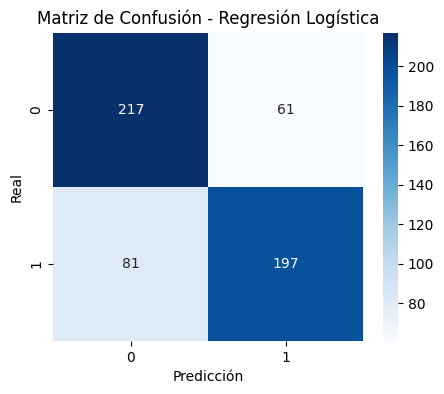

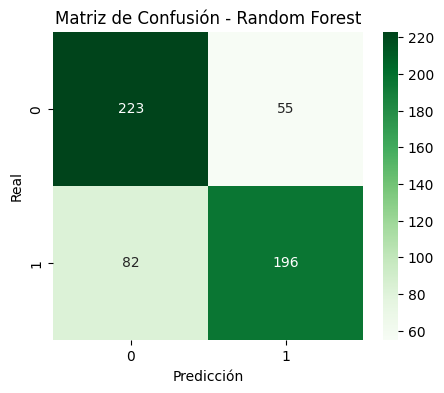

Precisión (Accuracy) de Regresión Logística: 0.7446
Precisión (Accuracy) de Random Forest: 0.7536


In [13]:
# Evaluar el modelo de Regresión Logística
y_pred_log = log_model.predict(X_test_tfidf)
print("Evaluación de Regresión Logística:")
print(classification_report(y_test, y_pred_log))

# Evaluar el modelo de Random Forest
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Evaluación de Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión para Regresión Logística
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Matriz de confusión para Random Forest
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Exactitud de los modelos
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Precisión (Accuracy) de Regresión Logística: {accuracy_log:.4f}")
print(f"Precisión (Accuracy) de Random Forest: {accuracy_rf:.4f}")


**Interpretación del resultado tras aplicar undersampling**

Después de aplicar undersampling, observamos que la distribución de clases ahora es equilibrada, lo que permite evaluar mejor el rendimiento de los modelos en ambas clases.

Análisis de los modelos

**Regresión Logística**

Clase 0 (negativas): 73%

Clase 1 (positivas): 76%

Recall

Clase 0: 78% → Es capaz de identificar correctamente la mayoría de las negativas.

Clase 1: 71% → Algo más baja, lo que indica que algunas reseñas positivas se etiquetan como negativas.

F1-score (equilibrio entre precisión y recall)

Ambas clases tienen un f1-score cercano a 0.74-0.75, lo que indica una buena consistencia.

Accuracy global: 74%

Conclusión: La regresión logística tiene un buen balance, con un ligero sesgo hacia las negativas (mejor recall en clase 0).

**Random Forest**

Clase 0: 73%
Clase 1: 78%

Recall

Clase 0: 80% → Detecta mejor los negativos.

Clase 1: 71% → Algo más baja, pierde algunas predicciones positivas.

F1-score: Ambas clases tienen un f1-score de 0.74-0.75, similar al de regresión logística.

Accuracy global: 75%

Conclusión:

Random Forest tiene mejor recall en clase 0 (negativas), lo que indica que predice mejor las críticas negativas.

Tiene una precisión ligeramente mejor en la clase positiva que la regresión logística.
Es un modelo más estable, con una accuracy del 75%.

Conclusión general:

Ambos modelos tienen rendimiento similar.
Random Forest tiene un mejor recall en clase 0 (negativas), por lo que es más robusto si queremos detectar reseñas negativas.
Regresión Logística es más estable y rápida, pero ligeramente menos precisa en positivos.


**Matriz de Confusión - Regresión Logística**

Valores en la matriz:

Verdaderos negativos (TN): 217 → Casos correctamente clasificados como negativos (0).

Falsos positivos (FP): 61 → Casos negativos que el modelo predijo erróneamente como positivos.

Falsos negativos (FN): 81 → Casos positivos que el modelo clasificó erróneamente como negativos.

Verdaderos positivos (TP): 197 → Casos correctamente clasificados como positivos (1).

Precisión del modelo: 74.46%

Es decir, el modelo clasifica correctamente 74.46% de los casos.
Hay una cantidad considerable de falsos negativos (81 casos), lo que indica que puede estar perdiendo algunos casos positivos.

**Matriz de Confusión - Random Forest**

Valores en la matriz:

Verdaderos negativos (TN): 223 → Casos correctamente clasificados como negativos.

Falsos positivos (FP): 55 → Casos negativos clasificados erróneamente como positivos.

Falsos negativos (FN): 82 → Casos positivos clasificados erróneamente como negativos.

Verdaderos positivos (TP): 196 → Casos correctamente clasificados como positivos.

Precisión del modelo: 75.36%

El modelo de Random Forest tiene una precisión ligeramente superior (75.36%) en comparación con la Regresión Logística (74.46%).
También presenta menos falsos positivos (55 vs. 61 en Regresión Logística), lo que indica que hace menos errores clasificando negativos como positivos.
